# VAE

In this section you are required to implement Variational Autoencoder. The general structure for VAE is given below. You can use it as a template.

Variational Autoencoder is a type of autoencoder that can be used as a generative model. It has a reparametrization trick in bottleneck part.

There are couple of studies you can examine before implementing the model.

Auto-Encoding Variational Bayes: 
https://arxiv.org/abs/1312.6114

Understanding Variational Autoencoders (VAEs): https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73



# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



# I ran the code on my local PC

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Tue Dec 10 16:02:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   54C    P0    71W / 275W |    256MiB / 11175MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Variable
import matplotlib.gridspec as gridspec
import cv2
import random

%matplotlib inline

device = torch.device("cuda")

b_size = 32

# Load the MNIST data

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=b_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=b_size, shuffle=True)

# Implement the VAE Architecture of your Design

Use Conv2d, ConvTranspose2d and Activation Layers to design a Variational Autoencoder Architecture

In [5]:
class VAE(torch.nn.Module):

    def __init__(self):

        super(VAE, self).__init__()
        
        self.fc_map_size = 8
        self.lin_encode_size = 8
        
        self.cv1 = nn.Conv2d(1, self.fc_map_size, 3)
        self.cv2 = nn.Conv2d(self.fc_map_size, self.fc_map_size*2, 3)
        
        self.flt = nn.Flatten()
        
        self.mean = nn.Linear(self.fc_map_size*2*24*24, self.lin_encode_size)
        self.logvar = nn.Linear(self.fc_map_size*2*24*24, self.lin_encode_size)
        
        self.dec_fc1 = nn.Linear(self.lin_encode_size, self.fc_map_size*2*24*24)
        
        self.ct1 = nn.ConvTranspose2d(self.fc_map_size*2, self.fc_map_size, 3)
        self.ct2 = nn.ConvTranspose2d(self.fc_map_size, 1, 3)

    def encode(self, x):
        
        h1 = F.relu(self.cv1(x))
        h2 = F.relu(self.cv2(h1))
        fln = self.flt(h2)
        
        mean = self.mean(fln)
        logvar = self.logvar(fln)
        
        return mean, logvar

    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def decode(self, z):
        
        h = F.relu(self.dec_fc1(z))
        h = h.view(-1,self.fc_map_size*2,24,24)
        h = F.relu(self.ct1(h))
        h = self.ct2(h)
        
        return torch.sigmoid(h)   
    
    def forward(self, x):

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        
        return self.decode(z), mu, logvar
    

In [6]:
vae = VAE().to(device)

# Initialization of the Optimizer: You can change the Parameters according to your needs

In [7]:
lr = 0.0002

optimizer = optim.Adam(vae.parameters(), lr=lr)

# Variational Autoencoder combines Reconstruction Loss and KL Divergence Loss

In [8]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE + KLD) / b_size

# Implement training loop

In [9]:
# Train mode enabled
vae.train()

num_epochs = 20
train_loss = 0
losses = []

for epoch in range(num_epochs):
    
    for n_batch, (batch,_) in enumerate(train_loader):
        
        # Sending data to the CUDA device
        batch = batch.to(device)
        
        # Zeroing the gradients of our optimizer
        optimizer.zero_grad()
        
        # Forward-Pass
        recon_batch, mu, logvar = vae(batch)
        
        # Calculating our VAE loss
        loss = loss_function(recon_batch, batch, mu, logvar)
        
        # Calculating the gradients
        loss.backward()
        
        # Adding it up onto the total loss
        train_loss += loss.item()
        
        # Running the optimizer on our VAE
        optimizer.step()
        
        if (n_batch + 1) % 900 == 0:
            print("epoch: {%d}, batch number: {%d}, error: {%.4f}" % 
                  (epoch + 1, n_batch + 1, loss.item(), ))
            
    train_loss /= (n_batch+1)
    losses.append(train_loss)
    train_loss = 0

epoch: {1}, batch number: {900}, error: {161.2327}
epoch: {1}, batch number: {1800}, error: {151.8484}
epoch: {2}, batch number: {900}, error: {139.3288}
epoch: {2}, batch number: {1800}, error: {130.7582}
epoch: {3}, batch number: {900}, error: {130.4708}
epoch: {3}, batch number: {1800}, error: {126.1330}
epoch: {4}, batch number: {900}, error: {128.2562}
epoch: {4}, batch number: {1800}, error: {121.9489}
epoch: {5}, batch number: {900}, error: {121.0166}
epoch: {5}, batch number: {1800}, error: {130.6862}
epoch: {6}, batch number: {900}, error: {131.4879}
epoch: {6}, batch number: {1800}, error: {128.3384}
epoch: {7}, batch number: {900}, error: {107.3627}
epoch: {7}, batch number: {1800}, error: {120.5458}
epoch: {8}, batch number: {900}, error: {114.8731}
epoch: {8}, batch number: {1800}, error: {115.1694}
epoch: {9}, batch number: {900}, error: {117.3911}
epoch: {9}, batch number: {1800}, error: {116.0857}
epoch: {10}, batch number: {900}, error: {115.2051}
epoch: {10}, batch nu

We create and implement our plotter function to see if our data is expected for us or not.

In [10]:
def show_images(images, rowlim):
    
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn*3, sqrtn*3))
    gs = gridspec.GridSpec(10, rowlim)
    gs.update(wspace=0.15, hspace=0.15)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        img = img.reshape([28, 28, 3])
        img = np.array(img)
        img = cv2.resize(img,None,fx=3,fy=3)
        plt.imshow(img)
        
    plt.show()

## Report the training loss curves and test results (generated images) for VAE. Also briefly discuss the results.

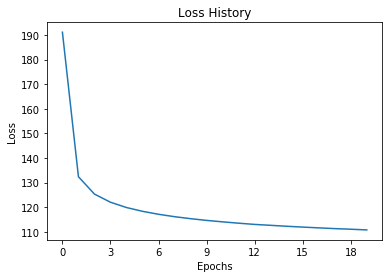

In [11]:
# Plotting VAE Loss
set_size = np.arange(len(losses))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(set_size, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History")
plt.show()

Original images and the corresponding VAE outputs:


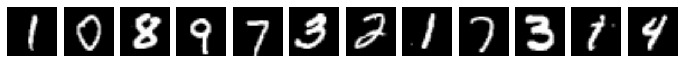

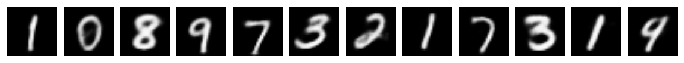

In [12]:
# Test mode enabled
vae.eval()

images = []
sample_arr = []

for n_batch, (batch,_) in enumerate(test_loader):
    
    with torch.no_grad():
        
        batch = batch.to(device)

        orig_img = batch[0].view([28,28,1]).expand(-1, -1, 3).cpu().detach().numpy()
        samples = vae.forward(batch)

        sample = samples[0][0]     
        sample = sample.view([28,28,1]).expand(-1, -1, 3).cpu().detach().numpy()

        images.append(orig_img)
        sample_arr.append(sample)
        
        if n_batch==11:
            break

images = np.array(images)
sample_arr = np.array(sample_arr)

print("Original images and the corresponding VAE outputs:")
show_images(images, 12)
show_images(sample_arr, 12)

Since the VAE outputs look similar to the original images with that shallow neural network, I think we can accept that as a success.

## Randomly generate a sample then traverse in its latent space dimensions (add small numbers to only one dimension) see how it affects generated images

 Sample 
----------------


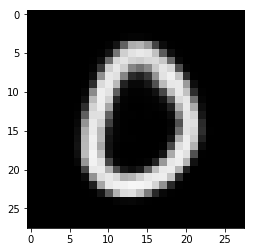


----------------------------------------------------------------------


 Sample with modified Axis 0, ID 27 
-----------------------------------


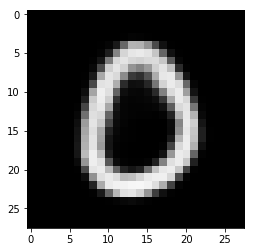

 Sample with modified Axis 0, ID 22 
-----------------------------------


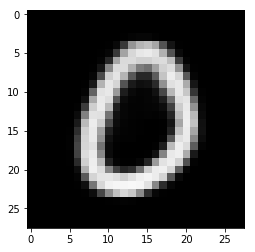

 Sample with modified Axis 0, ID 19 
-----------------------------------


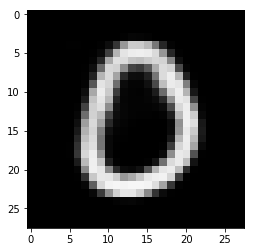

 Sample with modified Axis 0, ID 14 
-----------------------------------


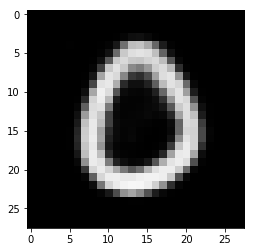

In [13]:
# Locking the gradients
vae.eval()

for n_batch, (batch,_) in enumerate(test_loader):
    
    batch = batch.to(device)
    samples = vae.forward(batch)
    sample = samples[0][0]     
    img_sample = sample.view([28,28,1]).expand(-1, -1, 3).cpu().detach().numpy()

    break
    
print(" Sample \n----------------")

plt.imshow(img_sample)
plt.show()

orig_sample = sample.detach().view([1,1,28,28])

print("\n"+"--"*35+"\n"*2)

for imcount in range(14,18):
    
    pick = random.randint(2,27)
    
    print(" Sample with modified Axis 0, ID "+str(pick)+" \n"+"-"*35)
    temp = orig_sample
    temp[0][0][pick][:] += 1e-1
    
    temp = vae.forward(temp)
    temp = temp[0][0] 
    
    temp = temp.view(28,28,1).expand(-1, -1, 3).cpu().detach().numpy()
    
    plt.imshow(temp)
    plt.show()

#### After you have completed the training, save your model using the following command

In [14]:
student_id = 504181504
torch.save(vae.state_dict(),'vae_{}.pth'.format(student_id))